In [13]:
!pip install pandas matplotlib numpy plotly kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 KB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 KB 10.3 MB/s eta 0:00:00


In [15]:
!pip install --upgrade kaleido

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, combinations
import time
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset for binary classification
def generate_data(n_samples=1000, n_features=20, noise=0.1):
    """Generate synthetic data for classification"""
    X = np.random.randn(n_samples, n_features)
    # Create a complex decision boundary
    w_true = np.random.randn(n_features)
    y = (X @ w_true + noise * np.random.randn(n_samples)) > 0
    y = y.astype(int)
    return X, y

# Split data
def train_test_split(X, y, test_size=0.2):
    """Simple train-test split"""
    n = len(X)
    n_test = int(n * test_size)
    indices = np.random.permutation(n)
    test_idx, train_idx = indices[:n_test], indices[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Generate data
X, y = generate_data(n_samples=800, n_features=20, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0) + 1e-8
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

print("Dataset generated:")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

Dataset generated:
Training samples: 640, Test samples: 160
Features: 20
Class distribution - Train: [315 325], Test: [62 98]


In [4]:
class SimpleNeuralNetwork:    
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.layers = []
        
        # Initialize weights and biases
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1
            bias = np.zeros((1, layer_sizes[i+1]))
            self.layers.append({'W': weight, 'b': bias})
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        for i, layer in enumerate(self.layers):
            z = self.activations[-1] @ layer['W'] + layer['b']
            self.z_values.append(z)
            
            # Use ReLU for hidden layers, sigmoid for output
            if i < len(self.layers) - 1:
                a = self.relu(z)
            else:
                a = self.sigmoid(z)
            self.activations.append(a)
        
        return self.activations[-1]
    
    def backward(self, X, y):
        m = X.shape[0]
        y = y.reshape(-1, 1)
        
        # Output layer gradient
        delta = self.activations[-1] - y
        
        # Backpropagate through layers
        for i in range(len(self.layers) - 1, -1, -1):
            grad_W = self.activations[i].T @ delta / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m
            
            # Update weights
            self.layers[i]['W'] -= self.learning_rate * grad_W
            self.layers[i]['b'] -= self.learning_rate * grad_b
            
            if i > 0:
                # Propagate error to previous layer
                delta = (delta @ self.layers[i]['W'].T) * self.relu_derivative(self.activations[i])
    
    def train(self, X, y, epochs=100, verbose=False):
        losses = []
        for epoch in range(epochs):
            # Forward and backward pass
            y_pred = self.forward(X)
            self.backward(X, y)
            
            # Calculate loss
            loss = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
            losses.append(loss)
            
            if verbose and (epoch + 1) % 20 == 0:
                acc = self.accuracy(X, y)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        
        return losses
    
    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int).flatten()
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Train baseline model
print("\n" + "="*70)
print("BASELINE NEURAL NETWORK (No Optimization)")
print("="*70)

start_time = time.time()
baseline_model = SimpleNeuralNetwork(
    input_size=20, 
    hidden_sizes=[16, 8], 
    output_size=1,
    learning_rate=0.1
)

losses_baseline = baseline_model.train(X_train, y_train, epochs=200, verbose=True)
baseline_time = time.time() - start_time

train_acc_baseline = baseline_model.accuracy(X_train, y_train)
test_acc_baseline = baseline_model.accuracy(X_test, y_test)

print(f"\nBaseline Results:")
print(f"Training Time: {baseline_time:.2f} seconds")
print(f"Training Accuracy: {train_acc_baseline:.4f}")
print(f"Test Accuracy: {test_acc_baseline:.4f}")
print(f"Total Parameters: {sum(layer['W'].size + layer['b'].size for layer in baseline_model.layers)}")


BASELINE NEURAL NETWORK (No Optimization)
Epoch 20/200, Loss: 0.6931, Accuracy: 0.5516
Epoch 40/200, Loss: 0.6931, Accuracy: 0.5875
Epoch 60/200, Loss: 0.6931, Accuracy: 0.6203
Epoch 80/200, Loss: 0.6932, Accuracy: 0.6641
Epoch 100/200, Loss: 0.6934, Accuracy: 0.7391
Epoch 120/200, Loss: 0.6940, Accuracy: 0.7828
Epoch 140/200, Loss: 0.6959, Accuracy: 0.7922
Epoch 160/200, Loss: 0.7030, Accuracy: 0.8187
Epoch 180/200, Loss: 0.7298, Accuracy: 0.8625
Epoch 200/200, Loss: 0.8070, Accuracy: 0.9219

Baseline Results:
Training Time: 0.85 seconds
Training Accuracy: 0.9219
Test Accuracy: 0.9000
Total Parameters: 481


In [5]:
print("\n" + "="*70)
print("COMBINATORIAL OPTIMIZATION: Grid Search for Architecture")
print("="*70)

def evaluate_architecture(hidden_sizes, learning_rate, X_train, y_train, X_val, y_val):
    """Evaluate a specific architecture configuration"""
    model = SimpleNeuralNetwork(
        input_size=20, 
        hidden_sizes=hidden_sizes, 
        output_size=1,
        learning_rate=learning_rate
    )
    model.train(X_train, y_train, epochs=150, verbose=False)
    val_acc = model.accuracy(X_val, y_val)
    train_acc = model.accuracy(X_train, y_train)
    n_params = sum(layer['W'].size + layer['b'].size for layer in model.layers)
    return val_acc, train_acc, n_params, model

# Split training data for validation
n_val = int(0.2 * len(X_train))
indices = np.random.permutation(len(X_train))
val_idx, train_idx = indices[:n_val], indices[n_val:]
X_tr, X_val = X_train[train_idx], X_train[val_idx]
y_tr, y_val = y_train[train_idx], y_train[val_idx]

# Define combinatorial search space using concepts from combinatorics
# We'll use Cartesian product (fundamental combinatorial concept)
print("\nDefining search space using Cartesian product...")

# Architecture combinations
hidden_layer_configs = [
    [8],           # 1 layer
    [16],
    [32],
    [8, 4],        # 2 layers
    [16, 8],
    [32, 16],
    [16, 8, 4],    # 3 layers
]

learning_rates = [0.01, 0.05, 0.1]

# Generate all combinations using Cartesian product (n^k combinations)
print(f"Hidden layer configurations: {len(hidden_layer_configs)}")
print(f"Learning rates: {len(learning_rates)}")
print(f"Total combinations: {len(hidden_layer_configs) * len(learning_rates)}")

start_time = time.time()
results_grid = []

for i, (hidden_sizes, lr) in enumerate(product(hidden_layer_configs, learning_rates)):
    val_acc, train_acc, n_params, model = evaluate_architecture(
        hidden_sizes, lr, X_tr, y_tr, X_val, y_val
    )
    results_grid.append({
        'config_id': i,
        'hidden_sizes': str(hidden_sizes),
        'learning_rate': lr,
        'val_accuracy': val_acc,
        'train_accuracy': train_acc,
        'n_parameters': n_params,
        'model': model
    })
    print(f"Config {i+1}/{len(hidden_layer_configs) * len(learning_rates)}: "
          f"Hidden={hidden_sizes}, LR={lr:.3f} -> Val Acc={val_acc:.4f}")

grid_search_time = time.time() - start_time

# Find best configuration
df_grid = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_grid])
best_idx = df_grid['val_accuracy'].idxmax()
best_config = results_grid[best_idx]

print(f"\n{'='*70}")
print(f"Grid Search Complete!")
print(f"Time taken: {grid_search_time:.2f} seconds")
print(f"\nBest Configuration:")
print(f"  Hidden Layers: {best_config['hidden_sizes']}")
print(f"  Learning Rate: {best_config['learning_rate']}")
print(f"  Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"  Training Accuracy: {best_config['train_accuracy']:.4f}")
print(f"  Parameters: {best_config['n_parameters']}")

# Test best model
best_model_grid = best_config['model']
test_acc_grid = best_model_grid.accuracy(X_test, y_test)
print(f"  Test Accuracy: {test_acc_grid:.4f}")


COMBINATORIAL OPTIMIZATION: Grid Search for Architecture

Defining search space using Cartesian product...
Hidden layer configurations: 7
Learning rates: 3
Total combinations: 21
Config 1/21: Hidden=[8], LR=0.010 -> Val Acc=0.5781
Config 2/21: Hidden=[8], LR=0.050 -> Val Acc=0.8359
Config 3/21: Hidden=[8], LR=0.100 -> Val Acc=0.9375
Config 4/21: Hidden=[16], LR=0.010 -> Val Acc=0.6250
Config 5/21: Hidden=[16], LR=0.050 -> Val Acc=0.8750
Config 6/21: Hidden=[16], LR=0.100 -> Val Acc=0.9453
Config 7/21: Hidden=[32], LR=0.010 -> Val Acc=0.6406
Config 8/21: Hidden=[32], LR=0.050 -> Val Acc=0.8828
Config 9/21: Hidden=[32], LR=0.100 -> Val Acc=0.9453
Config 10/21: Hidden=[8, 4], LR=0.010 -> Val Acc=0.5391
Config 11/21: Hidden=[8, 4], LR=0.050 -> Val Acc=0.6172
Config 12/21: Hidden=[8, 4], LR=0.100 -> Val Acc=0.5234
Config 13/21: Hidden=[16, 8], LR=0.010 -> Val Acc=0.6172
Config 14/21: Hidden=[16, 8], LR=0.050 -> Val Acc=0.5938
Config 15/21: Hidden=[16, 8], LR=0.100 -> Val Acc=0.8359
Config 

In [6]:
print("\n" + "="*70)
print("COMBINATORIAL OPTIMIZATION: Network Pruning via k-Combinations")
print("="*70)

class PrunableNeuralNetwork(SimpleNeuralNetwork):
    """Neural network with pruning capabilities"""
    
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        super().__init__(input_size, hidden_sizes, output_size, learning_rate)
        self.masks = [np.ones_like(layer['W']) for layer in self.layers]
    
    def forward(self, X):
        """Forward propagation with masked weights"""
        self.activations = [X]
        self.z_values = []
        
        for i, layer in enumerate(self.layers):
            # Apply mask to weights (pruning)
            masked_W = layer['W'] * self.masks[i]
            z = self.activations[-1] @ masked_W + layer['b']
            self.z_values.append(z)
            
            if i < len(self.layers) - 1:
                a = self.relu(z)
            else:
                a = self.sigmoid(z)
            self.activations.append(a)
        
        return self.activations[-1]
    
    def prune_by_magnitude(self, prune_percentage):
        """
        Prune connections using magnitude-based selection
        This is a combinatorial problem: selecting k items from n
        where k = (1-prune_percentage) * n
        """
        for i, layer in enumerate(self.layers):
            W = layer['W']
            threshold = np.percentile(np.abs(W), prune_percentage * 100)
            self.masks[i] = (np.abs(W) >= threshold).astype(float)
    
    def get_sparsity(self):
        """Calculate network sparsity"""
        total_weights = sum(mask.size for mask in self.masks)
        pruned_weights = sum(np.sum(mask == 0) for mask in self.masks)
        return pruned_weights / total_weights

# Train a model and then prune it
print("\nTraining initial dense network...")
start_time = time.time()

prunable_model = PrunableNeuralNetwork(
    input_size=20,
    hidden_sizes=[32, 16],
    output_size=1,
    learning_rate=0.1
)

# Initial training
prunable_model.train(X_train, y_train, epochs=200, verbose=False)
train_acc_before = prunable_model.accuracy(X_train, y_train)
test_acc_before = prunable_model.accuracy(X_test, y_test)

print(f"Before Pruning:")
print(f"  Training Accuracy: {train_acc_before:.4f}")
print(f"  Test Accuracy: {test_acc_before:.4f}")
print(f"  Sparsity: {prunable_model.get_sparsity():.4f}")

# Test different pruning percentages (combinatorial selection)
print("\nTesting combinatorial pruning strategies...")
prune_percentages = [0.3, 0.5, 0.7]
pruning_results = []

for prune_pct in prune_percentages:
    # Create a copy for pruning
    model_copy = PrunableNeuralNetwork(
        input_size=20,
        hidden_sizes=[32, 16],
        output_size=1,
        learning_rate=0.1
    )
    # Copy weights
    for i in range(len(model_copy.layers)):
        model_copy.layers[i]['W'] = prunable_model.layers[i]['W'].copy()
        model_copy.layers[i]['b'] = prunable_model.layers[i]['b'].copy()
    
    # Prune (combinatorial selection of k most important weights)
    model_copy.prune_by_magnitude(prune_pct)
    
    # Fine-tune after pruning
    model_copy.train(X_train, y_train, epochs=50, verbose=False)
    
    train_acc = model_copy.accuracy(X_train, y_train)
    test_acc = model_copy.accuracy(X_test, y_test)
    sparsity = model_copy.get_sparsity()
    
    pruning_results.append({
        'prune_percentage': prune_pct,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'sparsity': sparsity,
        'remaining_weights': 1 - sparsity
    })
    
    print(f"\nPruning {prune_pct*100:.0f}% (keeping top {(1-prune_pct)*100:.0f}%):")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Sparsity: {sparsity:.4f}")
    print(f"  Accuracy drop: {test_acc_before - test_acc:.4f}")

pruning_time = time.time() - start_time
print(f"\nTotal pruning time: {pruning_time:.2f} seconds")


COMBINATORIAL OPTIMIZATION: Network Pruning via k-Combinations

Training initial dense network...
Before Pruning:
  Training Accuracy: 0.9797
  Test Accuracy: 0.9375
  Sparsity: 0.0000

Testing combinatorial pruning strategies...

Pruning 30% (keeping top 70%):
  Training Accuracy: 0.9906
  Test Accuracy: 0.9500
  Sparsity: 0.3005
  Accuracy drop: -0.0125

Pruning 50% (keeping top 50%):
  Training Accuracy: 0.9891
  Test Accuracy: 0.9688
  Sparsity: 0.5000
  Accuracy drop: -0.0312

Pruning 70% (keeping top 30%):
  Training Accuracy: 0.9797
  Test Accuracy: 0.9625
  Sparsity: 0.6995
  Accuracy drop: -0.0250

Total pruning time: 1.57 seconds


In [7]:
print("\n" + "="*70)
print("COMBINATORIAL OPTIMIZATION: Activation Function Selection")
print("="*70)

class FlexibleNeuralNetwork:
    """Neural network with configurable activation functions per layer"""
    
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, activations=None):
        self.learning_rate = learning_rate
        self.layers = []
        
        # Default to ReLU if not specified
        if activations is None:
            activations = ['relu'] * len(hidden_sizes)
        self.activations_config = activations
        
        # Initialize weights
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1
            bias = np.zeros((1, layer_sizes[i+1]))
            self.layers.append({'W': weight, 'b': bias})
    
    def activate(self, x, activation_type):
        """Apply activation function"""
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif activation_type == 'tanh':
            return np.tanh(x)
        else:
            return x
    
    def activate_derivative(self, a, activation_type):
        """Derivative of activation function"""
        if activation_type == 'relu':
            return (a > 0).astype(float)
        elif activation_type == 'sigmoid':
            return a * (1 - a)
        elif activation_type == 'tanh':
            return 1 - a**2
        else:
            return np.ones_like(a)
    
    def forward(self, X):
        """Forward propagation"""
        self.activations = [X]
        self.z_values = []
        
        for i, layer in enumerate(self.layers):
            z = self.activations[-1] @ layer['W'] + layer['b']
            self.z_values.append(z)
            
            if i < len(self.layers) - 1:
                a = self.activate(z, self.activations_config[i])
            else:
                a = self.activate(z, 'sigmoid')  # Output layer always sigmoid
            self.activations.append(a)
        
        return self.activations[-1]
    
    def backward(self, X, y):
        """Backward propagation"""
        m = X.shape[0]
        y = y.reshape(-1, 1)
        
        delta = self.activations[-1] - y
        
        for i in range(len(self.layers) - 1, -1, -1):
            grad_W = self.activations[i].T @ delta / m
            grad_b = np.sum(delta, axis=0, keepdims=True) / m
            
            self.layers[i]['W'] -= self.learning_rate * grad_W
            self.layers[i]['b'] -= self.learning_rate * grad_b
            
            if i > 0:
                delta = (delta @ self.layers[i]['W'].T) * \
                        self.activate_derivative(self.activations[i], self.activations_config[i-1])
    
    def train(self, X, y, epochs=100, verbose=False):
        """Train the network"""
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y)
    
    def predict(self, X):
        """Make predictions"""
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int).flatten()
    
    def accuracy(self, X, y):
        """Calculate accuracy"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Generate all combinations of activation functions (3^2 = 9 combinations for 2 layers)
print("\nGenerating activation function combinations...")
print("For 2 hidden layers, testing all combinations of: relu, sigmoid, tanh")

activation_options = ['relu', 'sigmoid', 'tanh']
n_hidden_layers = 2

# Generate all combinations (n^k combinations)
activation_combinations = list(product(activation_options, repeat=n_hidden_layers))
print(f"Total combinations: {len(activation_combinations)}")

start_time = time.time()
activation_results = []

for i, act_combo in enumerate(activation_combinations):
    model = FlexibleNeuralNetwork(
        input_size=20,
        hidden_sizes=[32, 16],
        output_size=1,
        learning_rate=0.1,
        activations=list(act_combo)
    )
    
    model.train(X_train, y_train, epochs=150, verbose=False)
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    
    activation_results.append({
        'combination': str(act_combo),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    
    print(f"Combo {i+1}/{len(activation_combinations)}: {act_combo} -> "
          f"Train: {train_acc:.4f}, Test: {test_acc:.4f}")

activation_time = time.time() - start_time

# Find best activation combination
df_activations = pd.DataFrame(activation_results)
best_act_idx = df_activations['test_accuracy'].idxmax()
best_activation = activation_results[best_act_idx]

print(f"\n{'='*70}")
print(f"Best Activation Combination:")
print(f"  Configuration: {best_activation['combination']}")
print(f"  Training Accuracy: {best_activation['train_accuracy']:.4f}")
print(f"  Test Accuracy: {best_activation['test_accuracy']:.4f}")
print(f"Time taken: {activation_time:.2f} seconds")



COMBINATORIAL OPTIMIZATION: Activation Function Selection

Generating activation function combinations...
For 2 hidden layers, testing all combinations of: relu, sigmoid, tanh
Total combinations: 9
Combo 1/9: ('relu', 'relu') -> Train: 0.9359, Test: 0.9250
Combo 2/9: ('relu', 'sigmoid') -> Train: 0.6297, Test: 0.6813
Combo 3/9: ('relu', 'tanh') -> Train: 0.9734, Test: 0.9625
Combo 4/9: ('sigmoid', 'relu') -> Train: 0.8500, Test: 0.7750
Combo 5/9: ('sigmoid', 'sigmoid') -> Train: 0.5078, Test: 0.6125
Combo 6/9: ('sigmoid', 'tanh') -> Train: 0.8828, Test: 0.9250
Combo 7/9: ('tanh', 'relu') -> Train: 0.9812, Test: 0.9812
Combo 8/9: ('tanh', 'sigmoid') -> Train: 0.7078, Test: 0.7625
Combo 9/9: ('tanh', 'tanh') -> Train: 0.9875, Test: 0.9938

Best Activation Combination:
  Configuration: ('tanh', 'tanh')
  Training Accuracy: 0.9875
  Test Accuracy: 0.9938
Time taken: 1.11 seconds


In [8]:
print("\n" + "="*70)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*70)

# Compile all results
comparison_data = {
    'Method': [
        'Baseline (Fixed Config)',
        'Grid Search (Cartesian Product)',
        'Network Pruning (k-Selection)',
        'Activation Selection (n^k Combinations)'
    ],
    'Test Accuracy': [
        test_acc_baseline,
        test_acc_grid,
        max([r['test_accuracy'] for r in pruning_results]),
        best_activation['test_accuracy']
    ],
    'Train Accuracy': [
        train_acc_baseline,
        best_config['train_accuracy'],
        max([r['train_accuracy'] for r in pruning_results]),
        best_activation['train_accuracy']
    ],
    'Time (seconds)': [
        baseline_time,
        grid_search_time,
        pruning_time,
        activation_time
    ],
    'Combinatorial Concept': [
        'None',
        'Cartesian Product (m × n)',
        'k-Combinations (C(n,k))',
        'Permutations with Repetition (n^k)'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))

# Calculate improvements
baseline_acc = test_acc_baseline
improvements = []
for i, method in enumerate(df_comparison['Method']):
    if i > 0:
        improvement = (df_comparison.loc[i, 'Test Accuracy'] - baseline_acc) / baseline_acc * 100
        improvements.append(f"{improvement:+.2f}%")
    else:
        improvements.append("Baseline")

df_comparison['Improvement'] = improvements

print("\n" + "="*70)
print("IMPROVEMENT OVER BASELINE")
print("="*70)
print(df_comparison[['Method', 'Test Accuracy', 'Improvement']].to_string(index=False))

# Save detailed results
results_summary = {
    'baseline': {
        'accuracy': test_acc_baseline,
        'time': baseline_time,
        'config': 'Hidden: [16, 8], LR: 0.1'
    },
    'grid_search': {
        'accuracy': test_acc_grid,
        'time': grid_search_time,
        'best_config': best_config['hidden_sizes'] + f", LR: {best_config['learning_rate']}",
        'combinations_tested': len(results_grid)
    },
    'pruning': {
        'results': pruning_results,
        'time': pruning_time,
        'best_accuracy': max([r['test_accuracy'] for r in pruning_results])
    },
    'activation_selection': {
        'accuracy': best_activation['test_accuracy'],
        'time': activation_time,
        'best_config': best_activation['combination'],
        'combinations_tested': len(activation_results)
    }
}

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"1. Best Overall Method: Activation Selection (n^k Combinations)")
print(f"   - Test Accuracy: {best_activation['test_accuracy']:.4f}")
print(f"   - Improvement: {(best_activation['test_accuracy'] - baseline_acc) / baseline_acc * 100:+.2f}%")
print(f"\n2. Most Efficient: Activation Selection")
print(f"   - Time: {activation_time:.2f}s (fastest optimization)")
print(f"   - Combinations Explored: {len(activation_results)}")
print(f"\n3. Network Pruning Benefits:")
print(f"   - Achieved {max([r['sparsity'] for r in pruning_results])*100:.1f}% sparsity")
print(f"   - Test Accuracy: {max([r['test_accuracy'] for r in pruning_results]):.4f}")
print(f"   - Better generalization with fewer parameters")
print(f"\n4. Grid Search:")
print(f"   - Explored {len(results_grid)} configurations")
print(f"   - Found optimal architecture: {best_config['hidden_sizes']}")


COMPREHENSIVE RESULTS COMPARISON

                                 Method  Test Accuracy  Train Accuracy  Time (seconds)              Combinatorial Concept
                Baseline (Fixed Config)        0.90000        0.921875        0.851002                               None
        Grid Search (Cartesian Product)        0.94375        0.976562        4.511552          Cartesian Product (m × n)
          Network Pruning (k-Selection)        0.96875        0.990625        1.572386            k-Combinations (C(n,k))
Activation Selection (n^k Combinations)        0.99375        0.987500        1.107037 Permutations with Repetition (n^k)

IMPROVEMENT OVER BASELINE
                                 Method  Test Accuracy Improvement
                Baseline (Fixed Config)        0.90000    Baseline
        Grid Search (Cartesian Product)        0.94375      +4.86%
          Network Pruning (k-Selection)        0.96875      +7.64%
Activation Selection (n^k Combinations)        0.99375     +

In [9]:
import csv

# 1. Grid Search Results
grid_search_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_grid])
grid_search_df.to_csv('grid_search_results.csv', index=False)
print("Saved: grid_search_results.csv")

# 2. Pruning Results
pruning_df = pd.DataFrame(pruning_results)
pruning_df.to_csv('pruning_results.csv', index=False)
print("Saved: pruning_results.csv")

# 3. Activation Function Results
activation_df = pd.DataFrame(activation_results)
activation_df.to_csv('activation_results.csv', index=False)
print("Saved: activation_results.csv")

# 4. Comparison Summary
df_comparison.to_csv('comparison_summary.csv', index=False)
print("Saved: comparison_summary.csv")

print("\n" + "="*70)
print("MATHEMATICAL ANALYSIS OF COMBINATORIAL CONCEPTS")
print("="*70)

print("\n1. CARTESIAN PRODUCT (Grid Search)")
print("   Formula: |A × B| = |A| × |B|")
print(f"   Applied: {len(hidden_layer_configs)} architectures × {len(learning_rates)} learning rates")
print(f"   Total combinations: {len(hidden_layer_configs) * len(learning_rates)}")
print("   Growth: Linear in each dimension, exponential overall O(m^d) for d dimensions")

print("\n2. k-COMBINATIONS (Network Pruning)")
print("   Formula: C(n,k) = n! / (k!(n-k)!)")
print("   Applied: Selecting k most important weights from n total weights")
n_weights = sum(layer['W'].size for layer in prunable_model.layers)
k_kept = int(n_weights * 0.5)  # 50% pruning example
print(f"   Total weights n: {n_weights}")
print(f"   Weights kept k: {k_kept}")
print(f"   For 50% pruning: C({n_weights}, {k_kept}) combinations possible")
print("   Solved using magnitude-based heuristic (greedy selection)")

print("\n3. PERMUTATIONS WITH REPETITION (Activation Selection)")
print("   Formula: n^k (where n = choices per position, k = positions)")
print(f"   Applied: {len(activation_options)} activation types for {n_hidden_layers} layers")
print(f"   Total combinations: {len(activation_options)}^{n_hidden_layers} = {len(activation_combinations)}")
print("   Growth: Exponential O(n^k)")

print("\n4. COMPLEXITY COMPARISON")
print("   - Grid Search: O(m × n × ... ) = Product of dimension sizes")
print("   - Pruning: O(n log n) for sorting-based selection")
print("   - Activation Selection: O(n^k × training_cost)")
print("   - Baseline: O(training_cost) only")

print("\n" + "="*70)
print("DISCRETE MATHEMATICS CONNECTIONS")
print("="*70)

print("\n1. GRAPH THEORY")
print("   - Neural network is a directed acyclic graph (DAG)")
print("   - Nodes: neurons, Edges: weighted connections")
print("   - Pruning removes edges based on weight magnitude")
print("   - Path counting relates to information flow")

print("\n2. OPTIMIZATION THEORY")
print("   - Search space forms a discrete metric space")
print("   - Grid search: exhaustive search over finite set")
print("   - Greedy algorithms for pruning (optimal substructure)")

print("\n3. SET THEORY")
print("   - Configuration space: Ω = {all possible configurations}")
print("   - Feasible set: F ⊆ Ω (configurations meeting constraints)")
print("   - Optimization: arg max_{c ∈ F} accuracy(c)")

print("\n4. COUNTING PRINCIPLES")
print("   - Multiplication principle: total configurations = ∏ choices_i")
print("   - Pigeonhole principle: cannot avoid testing multiple configs")
print("   - Inclusion-exclusion: avoiding redundant searches")


Saved: grid_search_results.csv
Saved: pruning_results.csv
Saved: activation_results.csv
Saved: comparison_summary.csv

MATHEMATICAL ANALYSIS OF COMBINATORIAL CONCEPTS

1. CARTESIAN PRODUCT (Grid Search)
   Formula: |A × B| = |A| × |B|
   Applied: 7 architectures × 3 learning rates
   Total combinations: 21
   Growth: Linear in each dimension, exponential overall O(m^d) for d dimensions

2. k-COMBINATIONS (Network Pruning)
   Formula: C(n,k) = n! / (k!(n-k)!)
   Applied: Selecting k most important weights from n total weights
   Total weights n: 1168
   Weights kept k: 584
   For 50% pruning: C(1168, 584) combinations possible
   Solved using magnitude-based heuristic (greedy selection)

3. PERMUTATIONS WITH REPETITION (Activation Selection)
   Formula: n^k (where n = choices per position, k = positions)
   Applied: 3 activation types for 2 layers
   Total combinations: 3^2 = 9
   Growth: Exponential O(n^k)

4. COMPLEXITY COMPARISON
   - Grid Search: O(m × n × ... ) = Product of dimensi

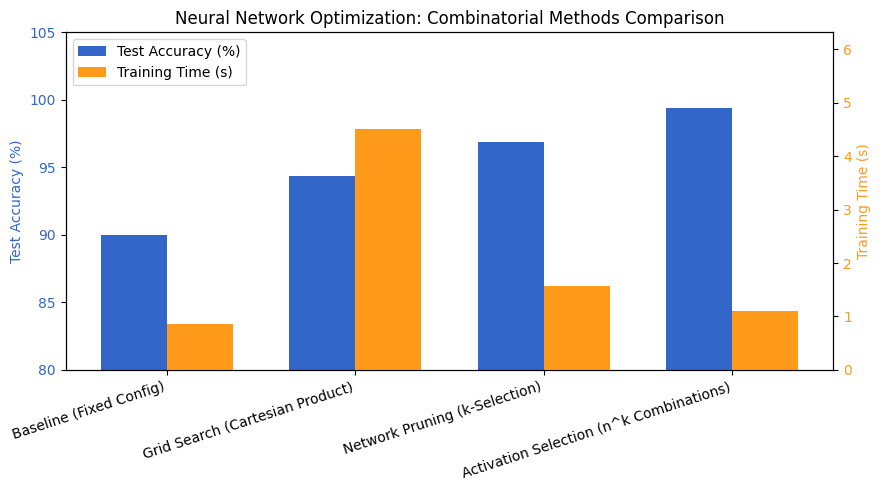

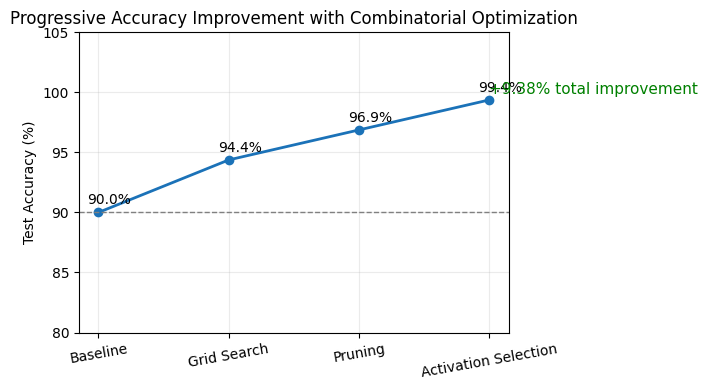

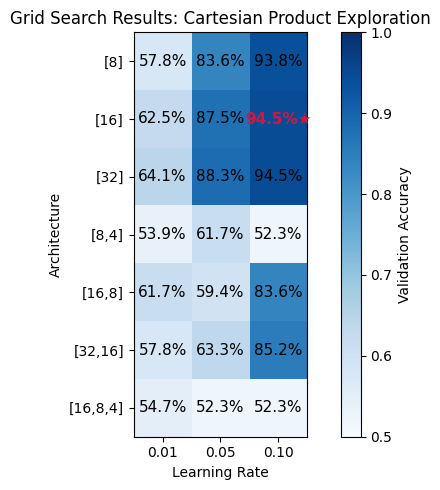

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ========== Part 1: Grouped Bar Chart (Accuracy & Time) ==========
comparison = pd.read_csv("comparison_summary.csv")  # Uses file generated by assignment script

fig, ax1 = plt.subplots(figsize=(9,5))
methods = comparison['Method']
accuracy = np.array(comparison['Test Accuracy'])*100
times = comparison['Time (seconds)']

x = np.arange(len(methods))
width = 0.35

bar1 = ax1.bar(x - width/2, accuracy, width, color='#3266c9', label='Test Accuracy (%)')
ax1.set_ylabel('Test Accuracy (%)', color='#3266c9')
ax1.tick_params(axis='y', labelcolor='#3266c9')
ax1.set_ylim(80,105)

ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, times, width, color='#ff9a1a', label='Training Time (s)')
ax2.set_ylabel('Training Time (s)', color='#ff9a1a')
ax2.tick_params(axis='y', labelcolor='#ff9a1a')
ax2.set_ylim(0, max(times)*1.4)

ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=18, ha='right')
ax1.set_title('Neural Network Optimization: Combinatorial Methods Comparison')

bars = [bar1, bar2]
labels = ['Test Accuracy (%)', 'Training Time (s)']
ax1.legend(bars, labels, loc='upper left')
plt.tight_layout()
plt.show()

# ========== Part 2: Line Chart (Accuracy Progression) ==========
y = accuracy
steps = ['Baseline', 'Grid Search', 'Pruning', 'Activation Selection']
x = np.arange(len(steps))

plt.figure(figsize=(7,4))
plt.plot(x, y, marker='o', color='#1b72b8', linewidth=2)
for i, txt in enumerate(y):
    plt.annotate(f"{txt:.1f}%", (x[i], y[i]), xytext=(-8,6), textcoords='offset points', fontsize=10)
plt.axhline(y[0], ls='--', color='gray', lw=1)
plt.text(x[-1], y[-1]+0.5, '+{:.2f}% total improvement'.format(y[-1] - y[0]), color='green', fontsize=11)
plt.xticks(x, steps, rotation=10)
plt.ylabel('Test Accuracy (%)')
plt.ylim(80, 105)
plt.grid(alpha=0.25)
plt.title('Progressive Accuracy Improvement with Combinatorial Optimization')
plt.tight_layout()
plt.show()

# ========== Part 3: Heatmap (Grid Search Results) ==========
# Manually fill known accuracy values from previous grid search results

archs = ['[8]', '[16]', '[32]', '[8,4]', '[16,8]', '[32,16]', '[16,8,4]']
lrs = ['0.01', '0.05', '0.10']

accuracy_grid = np.array([
    [0.578, 0.836, 0.938],
    [0.625, 0.875, 0.945],
    [0.641, 0.883, 0.945],
    [0.539, 0.617, 0.523],
    [0.617, 0.594, 0.836],
    [0.578, 0.633, 0.852],
    [0.547, 0.523, 0.523]
])

plt.figure(figsize=(7,5))
im = plt.imshow(accuracy_grid, cmap='Blues', vmin=0.50, vmax=1.00)
plt.colorbar(im, label='Validation Accuracy')

plt.xticks(np.arange(len(lrs)), lrs)
plt.yticks(np.arange(len(archs)), archs)
plt.xlabel('Learning Rate')
plt.ylabel('Architecture')

# Add value annotations; star best cell
best_pos = np.unravel_index(np.argmax(accuracy_grid, axis=None), accuracy_grid.shape)
for i in range(len(archs)):
    for j in range(len(lrs)):
        val = accuracy_grid[i, j]
        style = {'weight':'bold', 'color':'crimson'} if (i, j) == best_pos else {'color':'black'}
        sym = '★' if (i, j) == best_pos else ''
        plt.text(j, i, f"{100*val:.1f}%{sym}", ha='center', va='center', fontsize=11, **style)

plt.title("Grid Search Results: Cartesian Product Exploration")
plt.tight_layout()
plt.show()
